In [0]:
# Revised Neural Network

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from numpy import savetxt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

In [0]:
op_cases = 4
train_df = pd.read_csv("TrainData4.csv")
data_t = train_df.to_numpy()
x_train = data_t[:,1:29].T
y_train = data_t[:,29:33].T

test_df = pd.read_csv("TestData4.csv")
data_te = test_df.to_numpy()
x_test = data_te[:,1:29].T
y_test = data_te[:,29:33].T

In [41]:
print(y_train.shape)

(4, 320)


In [0]:
def initialize_parameters(n_x, n_h, n_y):    
    np.random.seed(1)

    W1 = np.random.randn(n_h,n_x) * .01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * .01
    b2 = np.zeros((n_y,1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters   

In [0]:
# calculate Z for forward propogation
def linear_forward(A, W, b):    
    
    Z = np.dot(W,A) + b

    assert(Z.shape == (W.shape[0], A.shape[1]))
    # storing parameters and A in cache
    cache = (A, W, b)
    
    return Z, cache

In [0]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)

    assert(A.shape==Z.shape)
    cache = Z
    return A, cache

def tanh(Z):
    A = ( np.exp(Z)-np.exp(-Z) )/( np.exp(Z)+np.exp(-Z))

    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

In [0]:
# forward propogation function
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)

    elif activation == "tanh":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = tanh(Z)
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [0]:
def compute_cost(AL,Y):
    m = Y.shape[1]

    cost = -1/m * np.sum( Y*np.log(AL + 1e-20) + (1-Y)*np.log(1-AL + 1e-20))
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    return cost

In [0]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ,A_prev.T)
    db = 1/m * np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [0]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s =  1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)

    assert(dZ.shape == Z.shape)
    return dZ

def tanh_backward(dA,cache):
    Z = cache
    t = ( np.exp(Z)-np.exp(-Z) )/( np.exp(Z)+np.exp(-Z))
    dtanh = 1 - np.power(t,2)
    dZ = dA * dtanh

    assert(dZ.shape==Z.shape)
    return dZ

In [0]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    # linear cache  -> A_prev, W, b
    # activation cache -> Z
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "tanh":
        dZ = tanh_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

In [0]:
# gradient descent
def update_parameters(parameters, grads, learning_rate):
   
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    ### END CODE HERE ###
    return parameters

In [0]:
n_x = 28
n_h = 20
n_y = 4
layers_dims = (n_x,n_h,n_y)

In [0]:
def two_layer_model(X,Y,layers_dims,learning_rate = .005, num_iterations = 3000,  print_cost=False):
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # initialising parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
        # varying learning rate with iterations
        if(i%10000==0):
            learning_rate = learning_rate*.6
        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, activation="relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation="sigmoid")
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu")
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        #if print_cost and i % 100 == 0:
        costs.append(cost)
        
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters     

In [63]:
print(y_train.size)
print(y_train.shape)

1280
(4, 320)


In [0]:
# using last layer as sigmoid layer
def predict(X,Y,parameters):
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    A1, cache1 = linear_activation_forward(X, W1, b1, activation="relu")
    A2, cache2 = linear_activation_forward(A1, W2, b2, activation="sigmoid")
    predictions = np.zeros(Y.shape)
    for j in range(Y.shape[1]):
        max=0;
        for i in range(Y.shape[0]):
            if(A2[i,j]>=max):
                i_max = i 
                max = A2[i,j]
        predictions[i_max,j] = 1
    
    # finding accuracy
    I = np.identity(Y.shape[0], dtype = 'float')
    acc = (float( np.sum(np.dot(Y,predictions.T)*I) + np.sum(np.dot(1-Y,1-predictions.T)*I) )) / float(Y.size) * 100
    return predictions,acc

Cost after iteration 0: 2.772826102107249
Cost after iteration 100: 2.263328538759136
Cost after iteration 200: 2.248391794465337
Cost after iteration 300: 2.2479686424576104
Cost after iteration 400: 2.247911600437086
Cost after iteration 500: 2.2478368063678027
Cost after iteration 600: 2.2477193300645575
Cost after iteration 700: 2.247533192406635
Cost after iteration 800: 2.2472372811088572
Cost after iteration 900: 2.246765928825946
Cost after iteration 1000: 2.246016970485976
Cost after iteration 1100: 2.244834947763209
Cost after iteration 1200: 2.2429935696410817
Cost after iteration 1300: 2.240151689735062
Cost after iteration 1400: 2.2358065705678825
Cost after iteration 1500: 2.2292521898840256
Cost after iteration 1600: 2.2195223798731605
Cost after iteration 1700: 2.205431645307654
Cost after iteration 1800: 2.1859063554746934
Cost after iteration 1900: 2.1600509530234633
Cost after iteration 2000: 2.1276740546831348
Cost after iteration 2100: 2.0903427292216334
Cost after

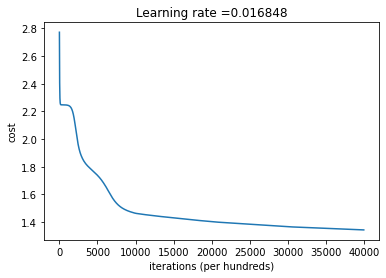

In [134]:
parameters = two_layer_model(x_train, y_train, layers_dims = (n_x, n_h, n_y), learning_rate = .13, num_iterations=40000 , print_cost=True)

In [0]:
predictions_train,acc = predict(x_train, y_train, parameters)
predictions_test,acc_test = predict(x_test, y_test, parameters)


In [136]:
# with relu as activation function
print(acc,acc_test)

83.75 80.0


In [131]:
# was tried with tanh as activation fn
print(acc,acc_test)
#print(predictions_train[:,0:5],predictions_test[:,0:5])
#print(y_train[:,0:5],y_test[:,0:5])

72.03125 70.0


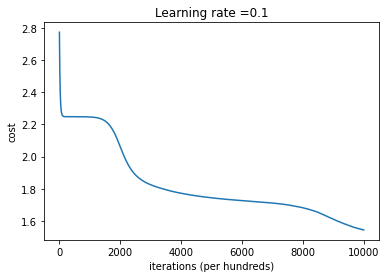

82.03125 75.625


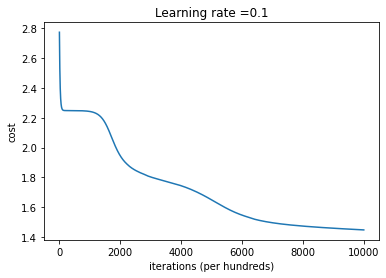

82.8125 76.875


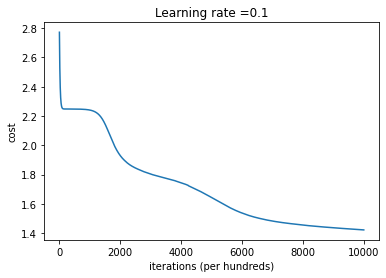

83.125 78.75


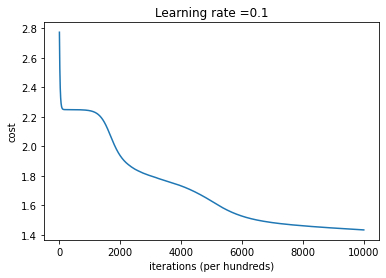

83.125 78.75


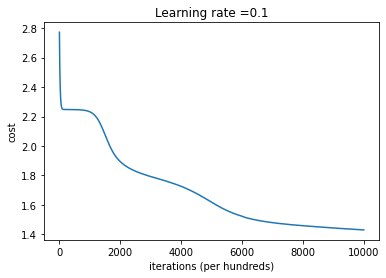

83.28125 78.125


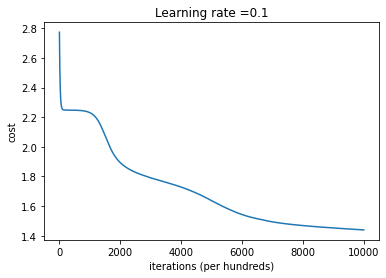

82.96875 77.5


In [109]:
#to find optimal no of hidden elemnts
hidden = [5,10,15,20,25,30]
#hidden = [15]
for i in range(len(hidden)):
    parameters = two_layer_model(x_train, y_train, layers_dims = (n_x, hidden[i], n_y), learning_rate = .1, num_iterations=10000 , print_cost=False)
    predictions_train,acc = predict(x_train, y_train, parameters)
    predictions_test,acc_test = predict(x_test, y_test, parameters)
    print(acc,acc_test)


In [103]:
print(hidden[i])

30
